In [ ]:
!pip install transformers torch scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Job_task/data/test.csv')

# Define label columns and text column
LABEL_COLUMNS = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
TEXT_COLUMN = 'feedback_text'


In [11]:
train_df.head()


,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [6]:
val_df.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


In [7]:
test_df.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
# dataset info
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             840 non-null    int64 
 1   feedback_text  840 non-null    object
 2   lang           840 non-null    object
 3   toxic          840 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 26.4+ KB

In [9]:
#check for missing values
def checking_m(train_df):
    null_v = train_df.isnull().sum().sort_values(ascending=False)
    null_percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(train_df)

,Missing_Number,Missing_Percent
id,0,0.0
feedback_text,0,0.0
toxic,0,0.0
abusive,0,0.0
vulgar,0,0.0
menace,0,0.0
offense,0,0.0
bigotry,0,0.0


In [10]:
#check for missing values
def checking_m(test_df):
    null_v = test_df.isnull().sum().sort_values(ascending=False)
    null_percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(test_df)

,Missing_Number,Missing_Percent
id,0,0.0
content,0,0.0
lang,0,0.0


In [11]:
#check for missing values
def checking_m(val_df):
    null_v = val_df.isnull().sum().sort_values(ascending=False)
    null_percent = (val_df.isnull().sum()/val_df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(val_df)

,Missing_Number,Missing_Percent
id,0,0.0
feedback_text,0,0.0
lang,0,0.0
toxic,0,0.0


In [12]:
train_df.toxic.value_counts()

,count
toxic,
0,21277
1,2196


In [13]:
val_df.toxic.value_counts()


,count
toxic,
0,706
1,134


# EDA and Preprocessing

In [14]:
# Define label columns and text column
LABEL_COLUMNS = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
TEXT_COLUMN = 'feedback_text'

In [15]:
# Create a count plot
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiple_countplots(train_df, columns, figsize=(12, 5)):

    n = len(columns)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    for i, col in enumerate(columns):
        sns.countplot(data=train_df, x=col, ax=axes[i])
        axes[i].set_title(f'Count Plot for {col}')
        axes[i].set_xlabel('Category')
        axes[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


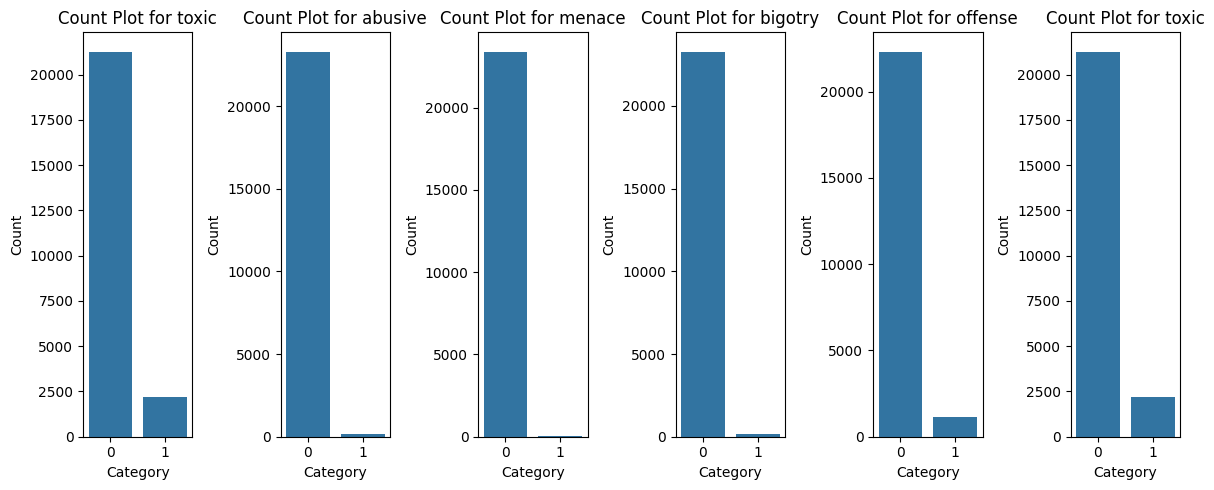

In [16]:
plot_multiple_countplots(train_df, ['toxic','abusive','menace','bigotry', 'offense','toxic'])

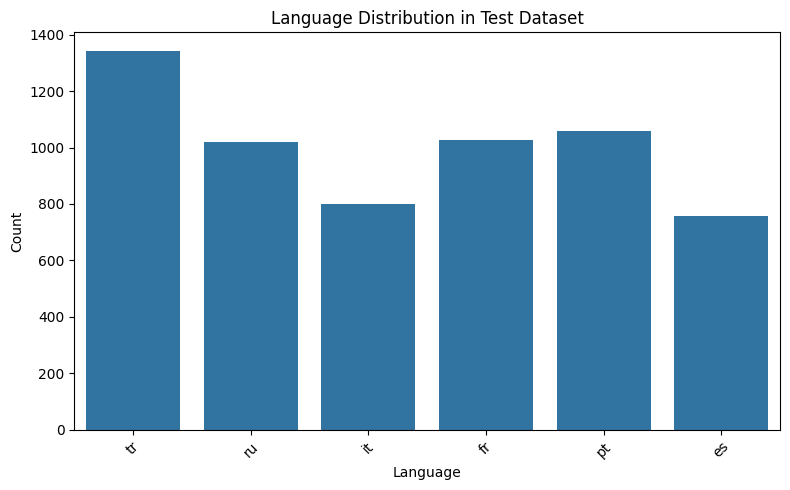

In [17]:
def plot_language_distribution(test_df, figsize=(8, 5)):

    plt.figure(figsize=figsize)
    sns.countplot(data=test_df, x='lang')
    plt.title('Language Distribution in Test Dataset')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the language distribution
plot_language_distribution(test_df)

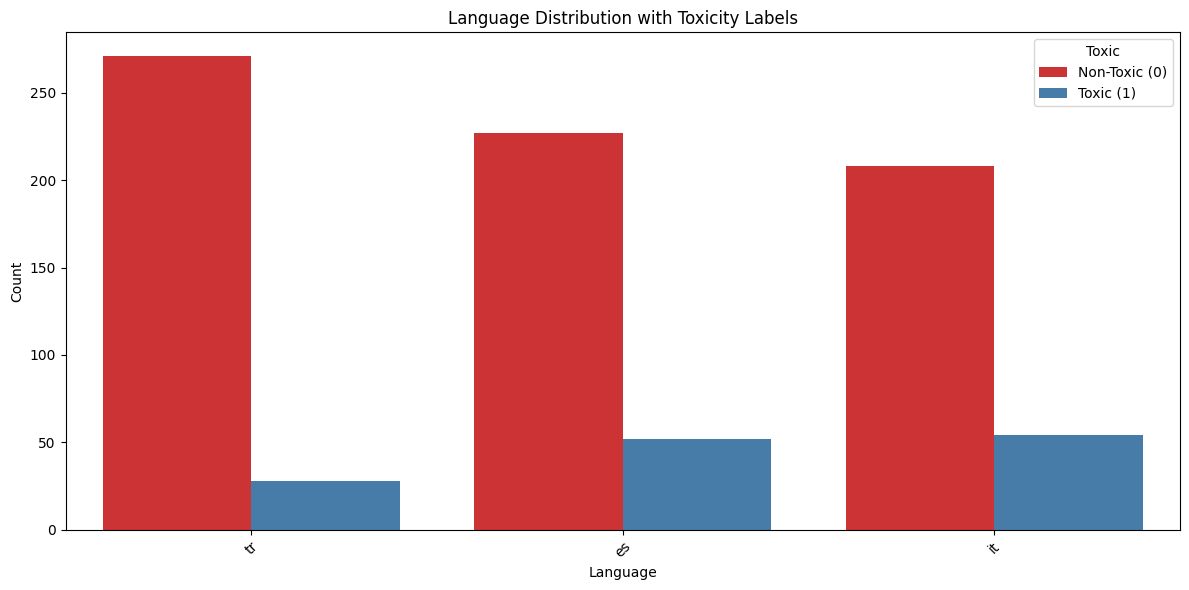

In [18]:
# Create a count plot for 'lang' with hue based on 'toxic'
def plot_lang_toxic_distribution(val_df, lang_col='lang', toxic_col='toxic', figsize=(12, 6)):

    plt.figure(figsize=figsize)

    sns.countplot(data=val_df, x=lang_col, hue=toxic_col, palette='Set1')

    plt.title('Language Distribution with Toxicity Labels')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title='Toxic', loc='upper right', labels=['Non-Toxic (0)', 'Toxic (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_lang_toxic_distribution(val_df)



 Checking Missing Values...
Missing values per column:

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64

 Plotting Label Distributions...


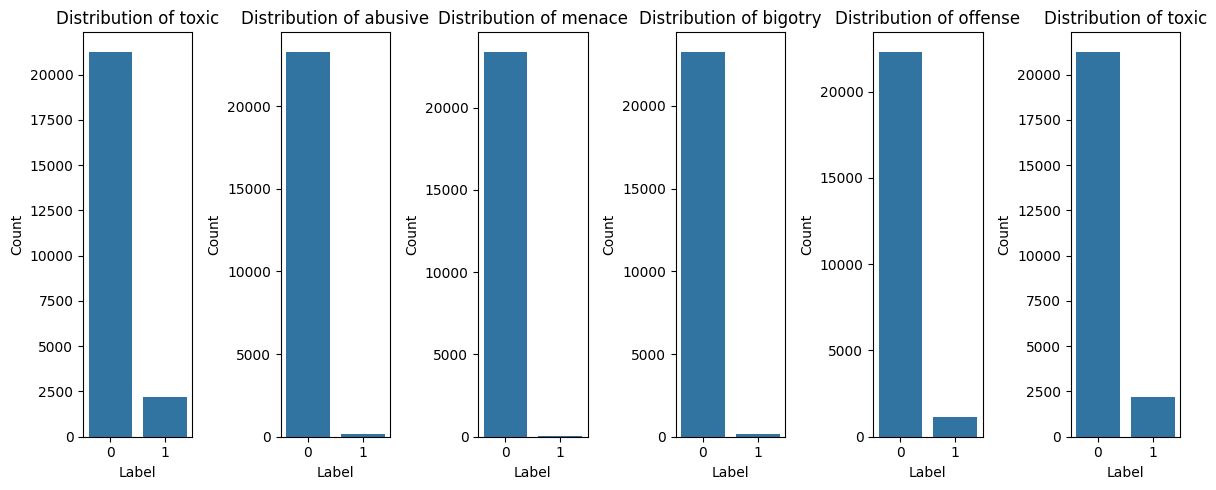


 Analyzing Sentence Structure...


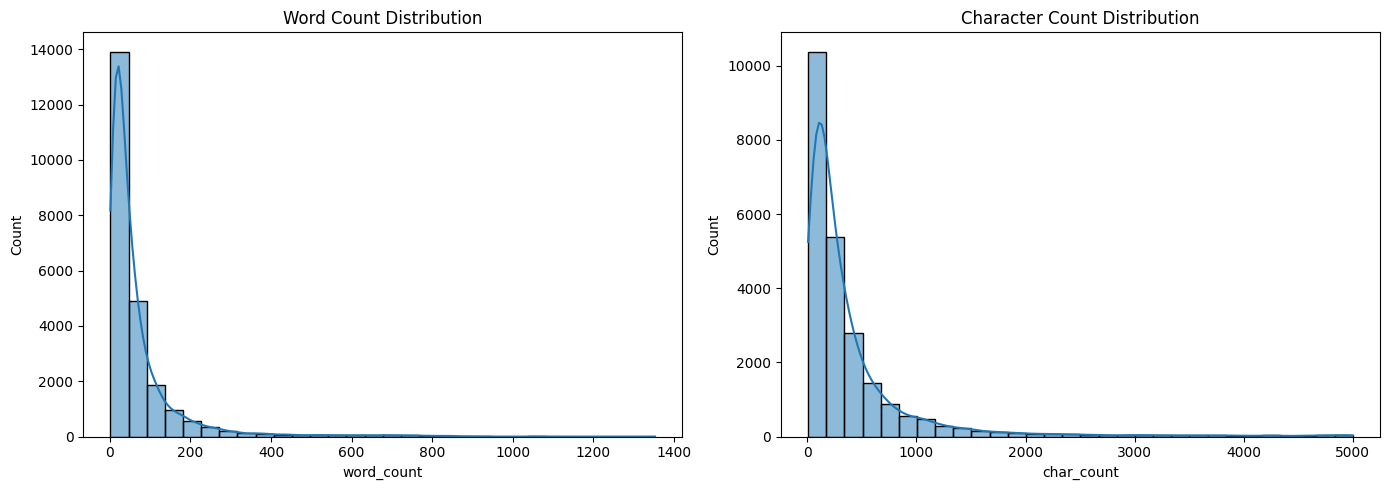


 Most Common Words in the Dataset...


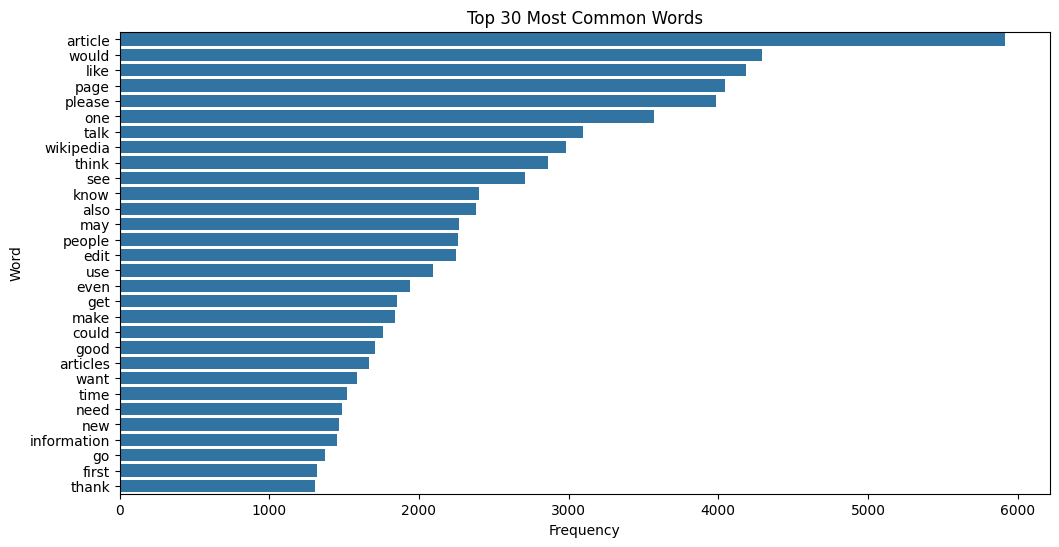

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

text_column = "feedback_text"  # name of the text column
label_columns = ['toxic', 'abusive', 'menace', 'bigotry', 'offense', 'toxic']


# 1. Label Distribution
# -------------------------------
def plot_label_distribution(train_df, labels):
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(labels):
        plt.subplot(1, len(labels), i + 1)
        sns.countplot(data=train_df, x=col)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Label')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 2. Sentence Length Analysis
# -------------------------------
def sentence_length_analysis(train_df, text_col):
    train_df['word_count'] = train_df[text_col].apply(lambda x: len(str(x).split()))
    train_df['char_count'] = train_df[text_col].apply(lambda x: len(str(x)))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(train_df['word_count'], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(train_df['char_count'], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

# 3. Most Common Words
# -------------------------------
def plot_common_words(train_df, text_col, top_n=30):
    stop_words = set(stopwords.words('english'))
    words = " ".join(train_df[text_col]).lower().split()
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)

    common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=common_df, y='Word', x='Frequency')
    plt.title(f"Top {top_n} Most Common Words")
    plt.show()

# 4. Missing Values
# -------------------------------
def check_missing_values(train_df):
    print("Missing values per column:\n")
    print(train_df.isnull().sum())

# 5. Run All EDA
# -------------------------------
def run_full_eda(train_df, text_col, label_cols):
    print(" Checking Missing Values...")
    check_missing_values(train_df)

    print("\n Plotting Label Distributions...")
    plot_label_distribution(train_df, label_cols)

    print("\n Analyzing Sentence Structure...")
    sentence_length_analysis(train_df, text_col)

    print("\n Most Common Words in the Dataset...")
    plot_common_words(train_df, text_col)

# Call  EDA function
run_full_eda(train_df, text_column, label_columns)


In [20]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textwrap import wrap

# Function to generate a single word cloud
def generate_wordcloud(data, title):
    word_freq = dict(data)
    wc = WordCloud(width=1080, height=740, max_words=150, colormap="Dark2", background_color="white").generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(f"Word Cloud for {title}", 60)), fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to generate word clouds for multiple target columns
def generate_wordclouds_for_labels(df, target_columns, text_column='feedback_text'):
    for label in target_columns:
        filtered_df = df[df[label] == 1].copy()
        filtered_df['tokens'] = filtered_df[text_column].apply(lambda x: str(x).lower().split())
        all_words = [word for tokens in filtered_df['tokens'] for word in tokens]
        word_counts = Counter(all_words)
        print(f"\n Generating word cloud for: {label}")
        generate_wordcloud(word_counts.most_common(200), f"{label} = 1")



 Generating word cloud for: toxic


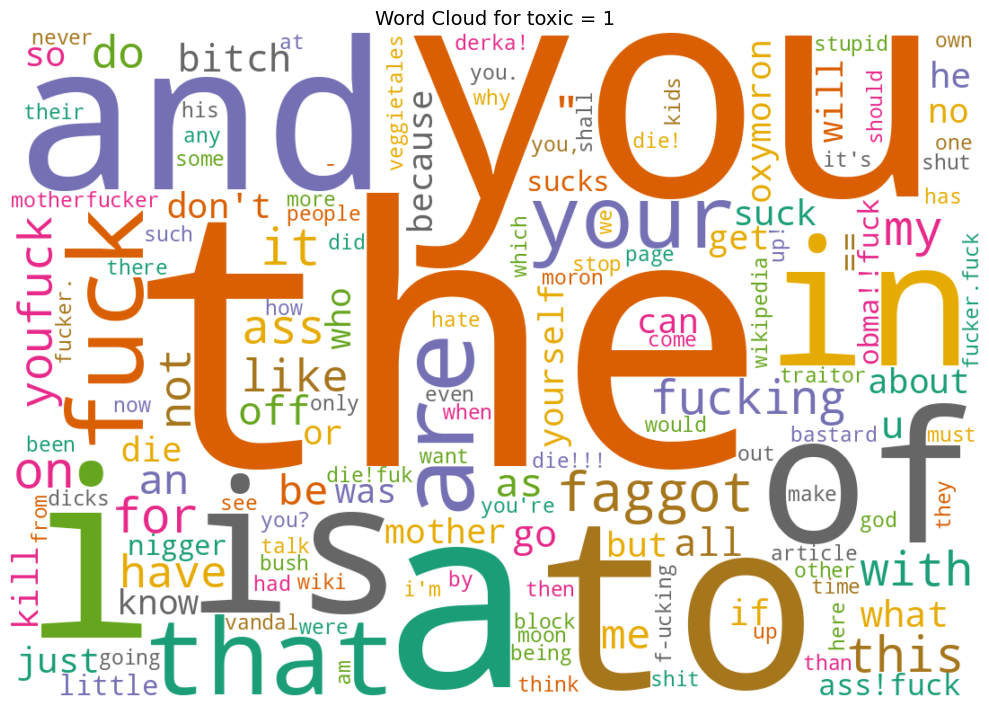


 Generating word cloud for: abusive


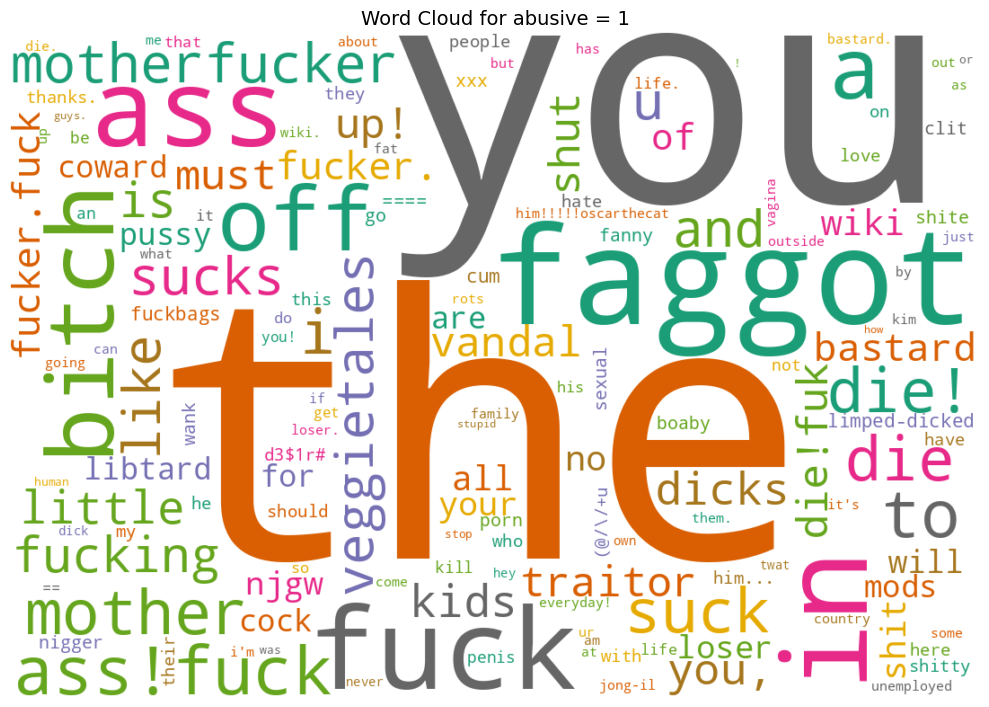


 Generating word cloud for: vulgar


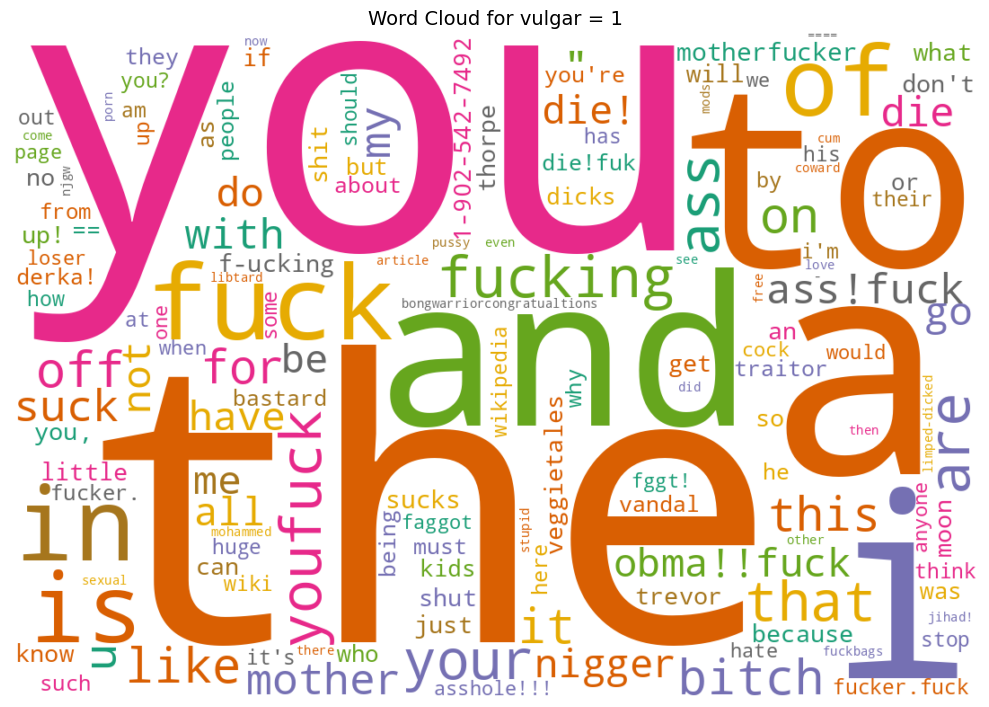


 Generating word cloud for: menace


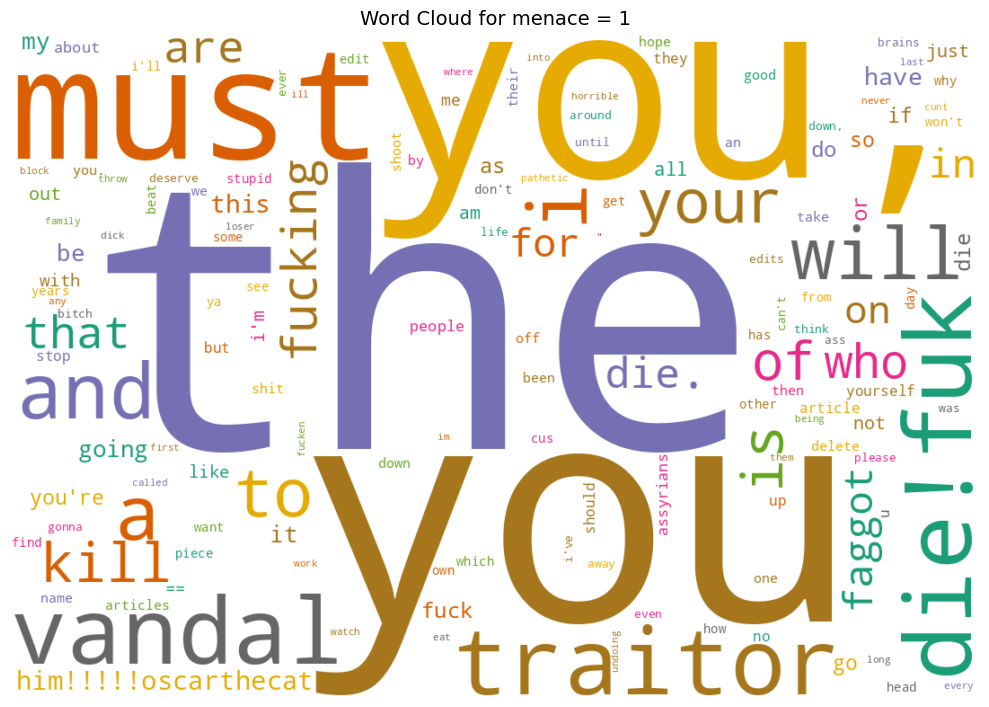


 Generating word cloud for: offense


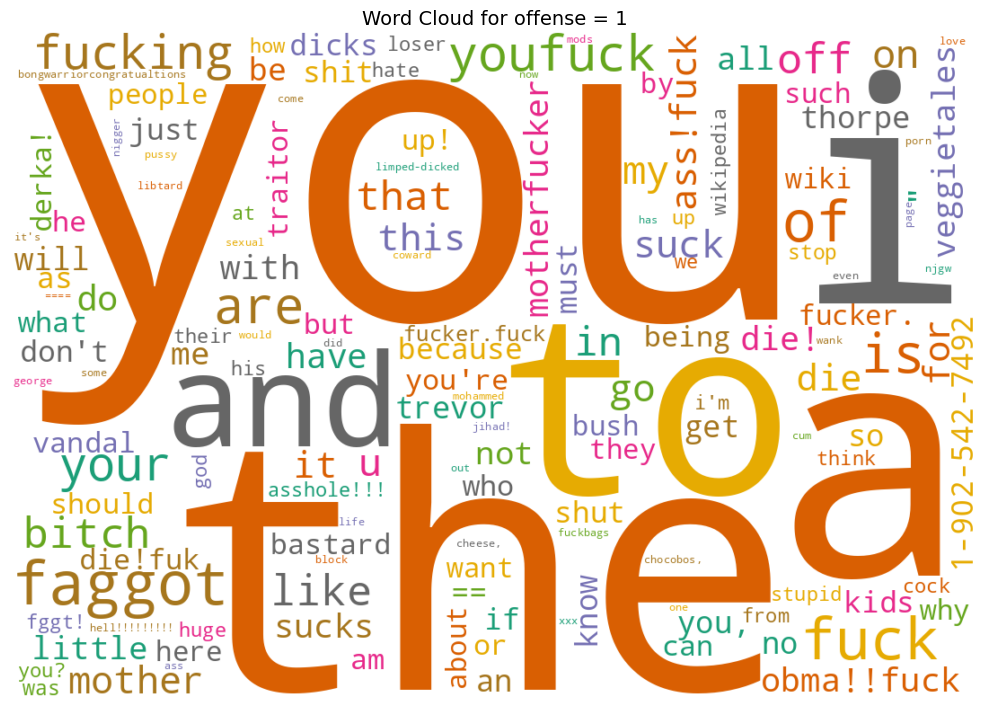


 Generating word cloud for: bigotry


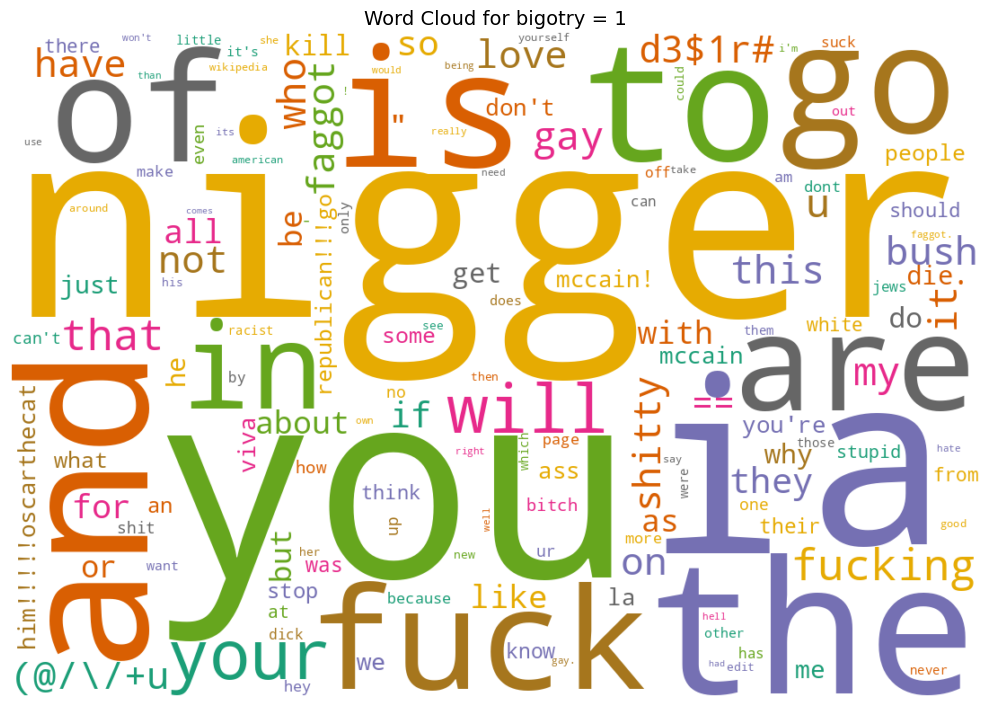

In [21]:
target_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
generate_wordclouds_for_labels(train_df, target_cols)

In [22]:
#Count Top Common Word
train_df['temp_list'] = train_df['feedback_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,66093
1,to,42513
2,of,32436
3,and,30349
4,a,29825
5,I,25200
6,is,24838
7,you,22561
8,that,20822
9,in,19769


# For validation Dataset

In [30]:
def sentence_length_analysis(val_df, text_col):
    val_df['word_count'] = val_df[text_col].apply(lambda x: len(str(x).split()))
    val_df['char_count'] = val_df[text_col].apply(lambda x: len(str(x)))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(val_df['word_count'], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(val_df['char_count'], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

# 3. Most Common Words
# -------------------------------
def plot_common_words(val_df, text_col, top_n=30):
    stop_words = set(stopwords.words('english'))
    words = " ".join(val_df[text_col]).lower().split()
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)

    common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=common_df, y='Word', x='Frequency')
    plt.title(f"Top {top_n} Most Common Words")
    plt.show()


 Analyzing Sentence Structure...


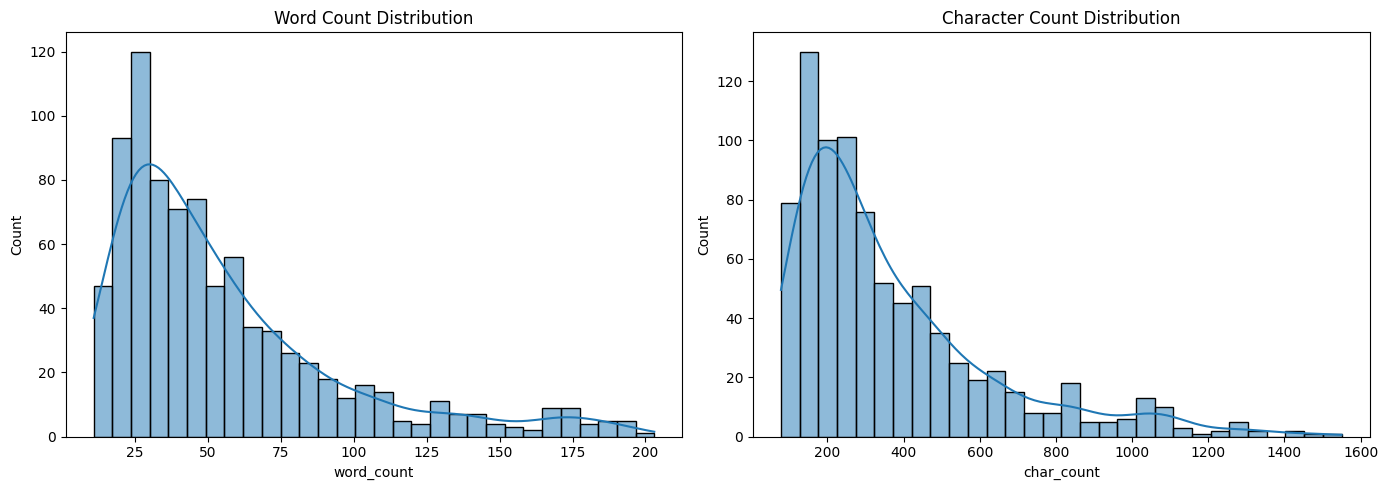


 Most Common Words in the Dataset...


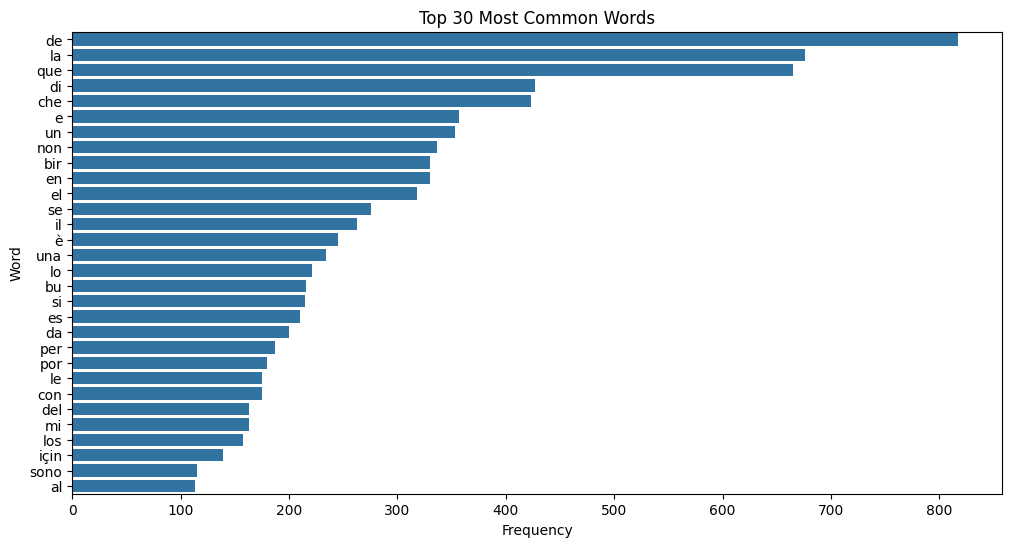

In [31]:
def run_full_eda(val_df, text_col):


    print("\n Analyzing Sentence Structure...")
    sentence_length_analysis(val_df, text_col)

    print("\n Most Common Words in the Dataset...")
    plot_common_words(val_df, text_col)

# Call the full EDA function
run_full_eda(val_df, text_column)


In [32]:
stopwords = set(stopwords.words('english'))

# Function to remove stopwords from a given text
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

# Function to clean the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions and handle common replacements
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)


    text = re.sub('\W', ' ', text)

    text = re.sub('\s+', ' ', text)

    text = text.strip(' ')

    return text

# Initialize the Snowball stemmer for English
stemmer = SnowballStemmer('english')


def stemming(sentence):
    stemmed_sentence = ""

    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "

    stemmed_sentence = stemmed_sentence.strip()

    return stemmed_sentence


In [33]:
# Clean the text data
train_df[TEXT_COLUMN] = train_df[TEXT_COLUMN].apply(clean_text)
val_df[TEXT_COLUMN] = val_df[TEXT_COLUMN].apply(clean_text)
test_df['content'] = test_df['content'].apply(clean_text)

In [34]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,word_count,char_count
0,281d77b7bebc2201,sounds good let me know when you are done and ...,0,0,0,0,0,0,13,68
1,716aac7bf3c63db1,i say something but it did not actually confir...,0,0,0,0,0,0,85,413
2,57cb318c6edcf10c,agustina barrientos modelo de piñeiro juán cru...,0,0,0,0,0,0,22,173
3,dc3bd70118d91b3a,fyi i enjoy licking strangers scrotal sacks es...,1,0,1,0,0,0,10,73
4,cf10d41f2997d233,how do you get a site many penguins have asked...,0,0,0,0,0,0,88,432


In [35]:
val_df.head()

,id,feedback_text,lang,toxic,word_count,char_count
0,1203,i yi tamam olabilir balkanlar maddesini gelişt...,tr,0,58,458
1,5871,por dios y la canción de john lennon http www ...,es,1,31,235
2,3590,selam öncelikle tebrik ederim bu arada kendin ...,tr,0,27,189
3,447,leggiti tutte le discussioni magari cancellale...,it,1,31,200
4,6634,a las tokitas nos vale que las jonaticas insul...,es,1,43,229


In [36]:
test_df.head()

,id,content,lang
0,0,doctor who adlı viki başlığına 12 doctor olara...,tr
1,1,вполне возможно но я пока не вижу необходимост...,ru
2,2,quindi tu sei uno di quelli conservativi che p...,it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,resim seldabagcan jpg resminde kaynak sorunu r...,tr


In [37]:
train_df[TEXT_COLUMN] = train_df[TEXT_COLUMN].apply(stemming)
val_df[TEXT_COLUMN] = val_df[TEXT_COLUMN].apply(stemming)
test_df['content'] = test_df['content'].apply(stemming)

In [38]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,word_count,char_count
0,281d77b7bebc2201,sound good let me know when you are done and i...,0,0,0,0,0,0,13,68
1,716aac7bf3c63db1,i say someth but it did not actual confirm any...,0,0,0,0,0,0,85,413
2,57cb318c6edcf10c,agustina barriento modelo de piñeiro juán cruz...,0,0,0,0,0,0,22,173
3,dc3bd70118d91b3a,fyi i enjoy lick stranger scrotal sack especi ...,1,0,1,0,0,0,10,73
4,cf10d41f2997d233,how do you get a site mani penguin have ask th...,0,0,0,0,0,0,88,432


In [39]:
test_df.head()

,id,content,lang
0,0,doctor who adlı viki başlığına 12 doctor olara...,tr
1,1,вполне возможно но я пока не вижу необходимост...,ru
2,2,quindi tu sei uno di quelli conservativi che p...,it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,resim seldabagcan jpg resmind kaynak sorunu re...,tr


In [40]:
val_df.head()

,id,feedback_text,lang,toxic,word_count,char_count
0,1203,i yi tamam olabilir balkanlar maddesini gelişt...,tr,0,58,458
1,5871,por dio y la canción de john lennon http www y...,es,1,31,235
2,3590,selam öncelikl tebrik ederim bu arada kendin a...,tr,0,27,189
3,447,leggiti tutt le discussioni magari cancellal e...,it,1,31,200
4,6634,a las tokita nos vale que las jonatica insulte...,es,1,43,229


In [41]:
train_df=train_df[['feedback_text',	'toxic',	'abusive',	'vulgar',	'menace',	'offense',	'bigotry'	]]
print(train_df.shape)

(23473, 7)


In [42]:
val_df=val_df[['feedback_text','lang','toxic']]
print(val_df.shape)

(840, 3)


In [54]:
test_df=test_df[['content',	'lang']]
print(test_df.shape)

(6000, 2)


In [55]:
# Custom PyTorch Dataset
# This dataset class tokenizes text data and prepares input tensors
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


In [56]:
# Use XLM-RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')




In [69]:
# Create datasets
train_dataset = ToxicDataset(train_df[TEXT_COLUMN].tolist(), train_df[LABEL_COLUMNS].values, tokenizer)
val_dataset = ToxicDataset(val_df['toxic'].tolist(), val_df['toxic'].values, tokenizer)
test_dataset = ToxicDataset(test_df['content'].tolist(), np.zeros((len(test_df), len(LABEL_COLUMNS))), tokenizer)


In [58]:
# Train Dataset – all 6 labels
train_dataset = ToxicDataset(
    train_df[TEXT_COLUMN].tolist(),
    train_df[LABEL_COLUMNS].values,
    tokenizer
)

# Validation Dataset – only toxic label
val_dataset = ToxicDataset(
    val_df[TEXT_COLUMN].tolist(),
    val_df[['toxic']].values,
    tokenizer
)

# Test Dataset – 'content' column and dummy labels
test_dataset = ToxicDataset(
    test_df['content'].tolist(),
    np.zeros((len(test_df), 1)),
    tokenizer
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [59]:
class ToxicClassifier(nn.Module):
    def __init__(self, num_labels):
        super(ToxicClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            'xlm-roberta-base',
            num_labels=num_labels
        )

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask).logits


In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxicClassifier(num_labels=len(LABEL_COLUMNS)).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Class weights (higher for minority classes)
class_weights = torch.tensor([1.0, 10.0, 10.0, 10.0, 10.0, 10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
num_epochs = 4
best_val_auc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation – only for toxic
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.BCEWithLogitsLoss()(outputs[:, 0], labels[:, 0])
            val_loss += loss.item()

            preds = torch.sigmoid(outputs[:, 0]).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels[:, 0].cpu().numpy())

    toxic_auc = roc_auc_score(all_labels, all_preds)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Val Loss: {val_loss / len(val_loader):.4f}")
    print(f"Toxic AUC: {toxic_auc:.4f}")

    if toxic_auc > best_val_auc:
        best_val_auc = toxic_auc
        torch.save(model.state_dict(), "best_model.pt")


Epoch 1/4
Train Loss: 0.2648
Val Loss: 0.6365
Toxic AUC: 0.7243
Epoch 2/4
Train Loss: 0.1770
Val Loss: 0.3755
Toxic AUC: 0.8722
Epoch 3/4
Train Loss: 0.1526
Val Loss: 0.5084
Toxic AUC: 0.8483
Epoch 4/4
Train Loss: 0.1464
Val Loss: 0.5861
Toxic AUC: 0.8007


In [63]:
from sklearn.metrics import classification_report, roc_auc_score
import torch
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs[:, 0]).cpu().numpy()  # only toxic
        all_preds.extend(preds)
        all_labels.extend(labels[:, 0].cpu().numpy())       # only toxic

# Convert predictions to binary
binary_preds = (np.array(all_preds) >= 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

# Show AUC and classification report
print("Toxic AUC:", roc_auc_score(true_labels, all_preds))
print("Classification Report for 'toxic':\n")
print(classification_report(true_labels, binary_preds, target_names=["Non-Toxic", "Toxic"]))


Toxic AUC: 0.872193564754133
Classification Report for 'toxic':

              precision    recall  f1-score   support

   Non-Toxic       0.85      1.00      0.92       706
       Toxic       0.79      0.08      0.15       134

    accuracy                           0.85       840
   macro avg       0.82      0.54      0.53       840
weighted avg       0.84      0.85      0.80       840



In [64]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

toxic_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs[:, 0]).cpu().numpy()  # Only toxic
        toxic_preds.extend(preds)

# Save predictions
test_df['toxic_prob'] = toxic_preds
test_df['toxic_label'] = (test_df['toxic_prob'] > 0.5).astype(int)
test_df[['content', 'toxic_prob', 'toxic_label']].to_csv("test_predictions.csv", index=False)


In [65]:
# Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Generate predictions on test set
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()
        test_preds.extend(preds)

# Convert predictions to binary
test_preds = np.array(test_preds)
test_binary_preds = (test_preds >= 0.5).astype(int)

# Output predictions for the test dataset
test_df['predicted_toxic'] = test_binary_preds[:, 0]
print(test_df[['content', 'predicted_toxic']])


                                                content  predicted_toxic
0     doctor who adlı viki başlığına 12 doctor olara...                0
1     вполне возможно но я пока не вижу необходимост...                0
2     quindi tu sei uno di quelli conservativi che p...                0
3     malesef gerçekleştirilmedi ancak şöyle bir şey...                0
4     resim seldabagcan jpg resmind kaynak sorunu re...                0
...                                                 ...              ...
5995  lütfen yazılarınıza imza atınız neyin orijinal...                0
5996  anarchist exist libertarien exist libertair ex...                0
5997  sağolun verdiğim kaynaklar tartışma sayfasına ...                0
5998  list des pay du mond et list des pay en 1920 s...                0
5999  v yi ter çevirir iki kere yazarsan m olur bu d...                0

[6000 rows x 2 columns]


In [66]:
def predict_toxicity(sentence, model, tokenizer, label_columns):

    model.eval()

    # Preprocess and tokenize the input sentence
    inputs = tokenizer(
        sentence,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    device = next(model.parameters()).device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.squeeze()
        probabilities = torch.sigmoid(logits).cpu().numpy()

    # Convert probabilities to binary predictions (threshold = 0.5)
    predictions = (probabilities >= 0.5).astype(int)

    # Create a dictionary of results
    results = {label: {"Prediction": pred, "Probability": prob}
               for label, pred, prob in zip(label_columns, predictions, probabilities)}

    return results


In [67]:
# Define the label columns
LABEL_COLUMNS = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

sentence = "You are the worst person I have ever met."

results = predict_toxicity(sentence, model, tokenizer, LABEL_COLUMNS)

print(f"Input Sentence: {sentence}\n")
for label, result in results.items():
    print(f"{label.capitalize()}: Prediction = {result['Prediction']}, Probability = {result['Probability']:.4f}")


Input Sentence: You are the worst person I have ever met.

Toxic: Prediction = 0, Probability = 0.2651
Abusive: Prediction = 0, Probability = 0.0242
Vulgar: Prediction = 0, Probability = 0.4475
Menace: Prediction = 0, Probability = 0.0490
Offense: Prediction = 0, Probability = 0.4968
Bigotry: Prediction = 0, Probability = 0.1015
